In [4]:
from Utils.load_data import load_dataset, load_dataset_labels
import numpy as np
from ClassificationModels.CNN_T import UCRDataset
import torch

from Utils.load_models import  load_pytorch_model


In [5]:
dataset='DistalPhalanxTW'

In [6]:
train_x =load_dataset(dataset_name=dataset, data_type="TRAIN_normalized")
train_y = np.array(load_dataset_labels(dataset_name=dataset, data_type="TRAIN_normalized"))

In [7]:


train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
model_path = f"models/{dataset}/cnn_norm.pth"
num_classes=len(np.unique(train_y))

model = load_pytorch_model(model_path, num_classes=num_classes)


In [8]:
num_classes

6

In [9]:
from TSInterpret.InterpretabilityModels.counterfactual.TSEvoCF import TSEvo
from Utils.load_models import model_batch_classify
y_pred = model_batch_classify(model_path=model_path,batch_of_timeseries=train_x,num_classes=num_classes)
exp =TSEvo(model= model,data=(train_x,np.array(y_pred)), mode = 'feat',backend='PYT',epochs =500)

/Users/brigt/Documents/GitHub/XAI_time_series/venv_server/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
y_pred

[0,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 0,
 5,
 0,
 5,
 0,
 5,
 5,
 0,
 0,
 5,
 5,
 5,
 0,
 0,
 5,
 5,
 5,
 0,
 5,
 5,
 2,
 5,
 5,
 5,
 5,
 5,
 2,
 5,
 5,
 2,
 1,
 0,
 5,
 0,
 0,
 5,
 5,
 5,
 5,
 1,
 0,
 0,
 5,
 0,
 2,
 2,
 0,
 1,
 1,
 1,
 5,
 5,
 2,
 5,
 0,
 2,
 5,
 5,
 5,
 5,
 5,
 5,
 0,
 0,
 0,
 5,
 0,
 0,
 5,
 3,
 5,
 5,
 0,
 1,
 2,
 5,
 5,
 0,
 5,
 5,
 2,
 5,
 5,
 0,
 5,
 1,
 0,
 5,
 0,
 1,
 0,
 0,
 5,
 5,
 2,
 5,
 5,
 5,
 0,
 5,
 0,
 5,
 5,
 5,
 0,
 5,
 5,
 0,
 0,
 5,
 5,
 5,
 0,
 2,
 5,
 5,
 5,
 0,
 0,
 5,
 0,
 5,
 5,
 0,
 2,
 2,
 5,
 5,
 5,
 0,
 0,
 5,
 5,
 3,
 3,
 2,
 5,
 5,
 2,
 5,
 0,
 0,
 5,
 0,
 0,
 2,
 5,
 5,
 2,
 0,
 5,
 0,
 5,
 5,
 0,
 1,
 5,
 5,
 5,
 0,
 1,
 5,
 0,
 5,
 2,
 5,
 2,
 1,
 0,
 5,
 0,
 5,
 5,
 5,
 0,
 5,
 5,
 1,
 0,
 5,
 5,
 5,
 0,
 5,
 5,
 1,
 5,
 0,
 1,
 5,
 0,
 5,
 0,
 5,
 0,
 5,
 5,
 0,
 2,
 5,
 5,
 0,
 0,
 5,
 5,
 5,
 5,
 0,
 0,
 0,
 5,
 5,
 0,
 0,
 5,
 5,
 0,
 2,
 0,
 5,
 5,
 5,
 0,
 5,
 5,
 5,
 5,
 2,
 5,
 0,
 2,
 5,
 5,
 5,
 5,
 0,
 5,
 0,
 5,


In [11]:
curr_instance = train_x[0].reshape(1,1,-1)
label =  np.array([y_pred[0]])
pop,label_cf=exp.explain(curr_instance,label)

No Target


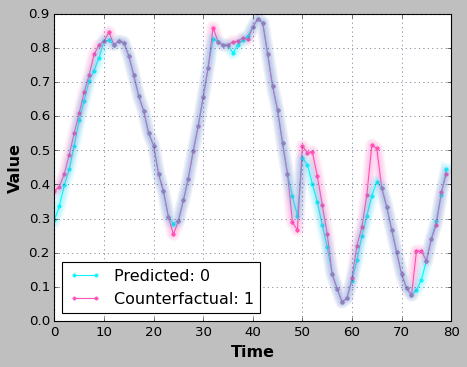

In [32]:

exp.plot_in_one(curr_instance[0],label[0],pop,np.argmax(label_cf),save_fig=None)

In [12]:
import cv2
import numpy as np
import torch
from torchvision import models  # Missing import added here
from torchvision.transforms import Compose, Normalize, ToTensor, Resize
from PIL import Image
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Load and preprocess image
def preprocess_image(image_path):
    image = Image.open(image_path)
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image).unsqueeze(0)
    return input_tensor, image

# 2. Load model
model = models.resnet50(pretrained=True)
model.eval()  # Set to evaluation mode

# 3. Prepare CAM
target_layers = [model.layer4[-1]]  # Last convolutional layer
cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

# 4. Process image and generate CAM
input_tensor, original_image = preprocess_image("your_image.jpg")
targets = None  # Uses highest scoring category by default

# Generate CAM mask
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# 5. Visualize results
# Convert original image to numpy array
rgb_img = np.array(original_image.resize((224, 224))) / 255.0

# Overlay CAM on image
visualization = show_cam_on_image(rgb_img, grayscale_cam[0], use_rgb=True)

# Display result
cv2.imshow("CAM", visualization[..., ::-1])  # Convert RGB to BGR for OpenCV
cv2.waitKey(0)

FileNotFoundError: [Errno 2] No such file or directory: 'your_image.jpg'

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# =====================
# 1. Generate Mock Time Series Data
# =====================
def generate_mock_timeseries(num_samples=100, seq_length=100, num_classes=3):
    """Generate mock time series data with three classes: sine, square, and sawtooth waves"""
    X = np.zeros((num_samples, 1, seq_length))  # Shape: (samples, channels, length)
    y = np.zeros(num_samples, dtype=int)

    for i in range(num_samples):
        t = np.linspace(0, 4*np.pi, seq_length)
        class_idx = np.random.randint(0, num_classes)

        if class_idx == 0:  # Sine wave
            X[i, 0] = np.sin(t) + np.random.normal(0, 0.1, seq_length)
        elif class_idx == 1:  # Square wave
            X[i, 0] = np.sign(np.sin(t)) + np.random.normal(0, 0.1, seq_length)
        else:  # Sawtooth wave
            X[i, 0] = 2 * (t/(2*np.pi) - np.floor(0.5 + t/(2*np.pi))) + np.random.normal(0, 0.1, seq_length)

        y[i] = class_idx

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y)

# Generate data
X, y = generate_mock_timeseries(num_samples=300, seq_length=100, num_classes=3)
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# =====================
# 2. Define 1D-CNN Model
# =====================
class TimeSeriesCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # Treat time series as 2D: [channels, height=1, width=time_steps]
            nn.Conv2d(1, 16, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),

            nn.Conv2d(16, 32, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),

            nn.Conv2d(32, 64, kernel_size=(1, 3), padding=(0, 1)),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 1 * 25, 128),  # Adjusted for pooling
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Add dummy height dimension: [batch, 1, 1, seq_length]
        x = x.unsqueeze(2)
        features = self.conv_layers(x)
        return self.classifier(features)

model = TimeSeriesCNN(num_classes=3)

# =====================
# 3. Train the Model
# =====================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# =====================
# 4. Implement Grad-CAM
# =====================
# Select last convolutional layer as target
target_layer = model.conv_layers[-1]

# Reshape input: [channels, height=1, width=time_steps]
input_tensor = X[0:1]  # First sample

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=[target_layer])

# Create targets (use predicted class)
with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, dim=1).item()
targets = [ClassifierOutputTarget(pred_class)]

# Generate CAM
grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(2), targets=targets)
grayscale_cam = grayscale_cam[0]  # Get CAM for first sample

# =====================
# 5. Visualization
# =====================
# Normalize time series for visualization
ts_normalized = (input_tensor.numpy()[0, 0] - input_tensor.numpy()[0, 0].min())
ts_normalized = ts_normalized / ts_normalized.max()

# Create RGB image from time series (required by show_cam_on_image)
rgb_img = np.stack([ts_normalized] * 3, axis=-1)

# Overlay CAM on time series
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=0.5)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title("Original Time Series")
plt.plot(ts_normalized, label=f"Class: {y[0].item()}")
plt.legend()

plt.subplot(2, 1, 2)
plt.title("Grad-CAM Activation Map")
plt.imshow(cam_image, aspect='auto', cmap='viridis', extent=[0, len(ts_normalized), -0.5, 0.5])
plt.yticks([])
plt.xlabel("Time Steps")
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [1]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

model = resnet50(pretrained=True)
model.eval()  # Set to evaluation mode
target_layers = [model.layer4[-1]]

# Load and preprocess an image
image_path = "Doog.jpeg"  # Replace with your image path
img = Image.open(image_path).convert('RGB')

# Define preprocessing transforms (same as ImageNet preprocessing)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create input tensor
input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

# Also create rgb_img for visualization (normalized to [0,1])
rgb_img = np.array(img.resize((224, 224))) / 255.0

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(281)]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    # You can also get the model outputs without having to redo inference
    model_outputs = cam.outputs

/Users/brigt/Documents/GitHub/XAI_time_series/venv_server/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/brigt/Documents/GitHub/XAI_time_series/venv_server/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
visualization

array([[[ 83,  94, 125],
        [ 83,  94, 125],
        [ 83,  94, 125],
        ...,
        [ 81,  92, 122],
        [ 81,  92, 122],
        [ 81,  92, 122]],

       [[ 83,  94, 125],
        [ 83,  94, 125],
        [ 83,  94, 125],
        ...,
        [ 81,  92, 122],
        [ 81,  92, 122],
        [ 81,  92, 122]],

       [[ 83,  94, 125],
        [ 83,  94, 126],
        [ 83,  94, 126],
        ...,
        [ 81,  92, 122],
        [ 81,  92, 122],
        [ 81,  92, 122]],

       ...,

       [[ 52,  63, 132],
        [ 51,  62, 131],
        [ 52,  62, 132],
        ...,
        [ 61,  61, 150],
        [ 59,  57, 146],
        [ 59,  54, 144]],

       [[ 49,  61, 128],
        [ 49,  61, 129],
        [ 52,  64, 132],
        ...,
        [ 60,  64, 153],
        [ 59,  61, 150],
        [ 59,  58, 149]],

       [[ 49,  61, 125],
        [ 49,  61, 127],
        [ 51,  64, 131],
        ...,
        [ 59,  65, 153],
        [ 59,  63, 152],
        [ 61,  62, 152]]

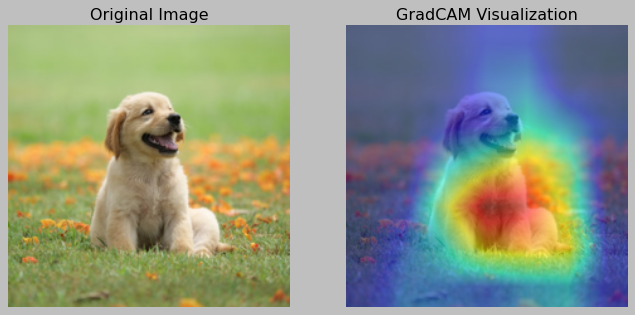

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title('GradCAM Visualization')
plt.axis('off')
plt.show()

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Example time series model (you can replace this with your own model)
class TimeSeriesModel(nn.Module):
    def __init__(self, input_size=10, hidden_size=64, num_classes=3, sequence_length=100):
        super(TimeSeriesModel, self).__init__()
        self.sequence_length = sequence_length
        self.input_size = input_size

        # CNN layers for feature extraction
        self.conv1 = nn.Conv1d(input_size, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)

        # LSTM for sequential processing
        self.lstm = nn.LSTM(128, hidden_size, batch_first=True, bidirectional=True)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        # Transpose for conv1d: (batch_size, input_size, sequence_length)
        x = x.transpose(1, 2)

        # Apply conv layers
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))  # This will be our target layer

        # Transpose back for LSTM: (batch_size, sequence_length, features)
        x = x.transpose(1, 2)

        # LSTM
        lstm_out, (hidden, cell) = self.lstm(x)

        # Use the last output for classification
        output = self.classifier(lstm_out[:, -1, :])

        return output

# Initialize model
model = TimeSeriesModel(input_size=10, hidden_size=64, num_classes=3, sequence_length=100)
model.eval()

# Target layer for GradCAM (the last conv layer before LSTM)
target_layers = [model.conv3]

# Create sample time series input tensor
# Shape: (batch_size, sequence_length, input_size)
batch_size = 1
sequence_length = 100
input_size = 10

# Generate synthetic time series data (replace with your actual data)
np.random.seed(42)
input_tensor = torch.randn(batch_size, sequence_length, input_size)

# You can also load real time series data like this:
# input_tensor = torch.tensor(your_time_series_data).float().unsqueeze(0)

# Specify target class for GradCAM
target_class = 1  # Change this to your desired class
targets = [ClassifierOutputTarget(target_class)]

# Apply GradCAM
with GradCAM(model=model, target_layers=target_layers) as cam:
    # Get the gradients
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    # grayscale_cam shape: (batch_size, sequence_length)
    grayscale_cam = grayscale_cam[0, :]  # Remove batch dimension

    # Get model predictions
    model_outputs = cam.outputs
    predicted_class = torch.argmax(model_outputs, dim=1).item()
    confidence = torch.softmax(model_outputs, dim=1)[0, predicted_class].item()

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.3f}")

# Visualization for time series
def visualize_time_series_gradcam(input_data, gradcam_weights, feature_names=None):
    """
    Visualize GradCAM results for time series data

    Args:
        input_data: Original time series data (sequence_length, input_size)
        gradcam_weights: GradCAM weights (sequence_length,)
        feature_names: Optional list of feature names
    """
    input_data = input_data.squeeze().numpy()  # Remove batch dim and convert to numpy
    sequence_length, input_size = input_data.shape

    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(input_size)]

    # Create subplots
    fig, axes = plt.subplots(input_size + 1, 1, figsize=(15, 2 * (input_size + 1)))
    if input_size == 1:
        axes = [axes]

    # Time steps
    time_steps = np.arange(sequence_length)

    # Plot each feature with GradCAM overlay
    for i in range(input_size):
        ax = axes[i]

        # Create color map based on GradCAM weights
        colors = plt.cm.Reds(gradcam_weights / gradcam_weights.max())

        # Plot the time series
        ax.plot(time_steps, input_data[:, i], 'b-', linewidth=1, alpha=0.7)

        # Add GradCAM heatmap as background
        for j in range(len(time_steps) - 1):
            ax.axvspan(time_steps[j], time_steps[j + 1],
                      alpha=colors[j][3] * 0.5, color='red')

        ax.set_ylabel(feature_names[i])
        ax.set_title(f'{feature_names[i]} with GradCAM Importance')
        ax.grid(True, alpha=0.3)

    # Plot GradCAM weights separately
    ax_gradcam = axes[-1]
    ax_gradcam.plot(time_steps, gradcam_weights, 'r-', linewidth=2)
    ax_gradcam.fill_between(time_steps, gradcam_weights, alpha=0.3, color='red')
    ax_gradcam.set_ylabel('GradCAM\nImportance')
    ax_gradcam.set_xlabel('Time Steps')
    ax_gradcam.set_title('GradCAM Importance Over Time')
    ax_gradcam.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Visualize the results
visualize_time_series_gradcam(input_tensor, gradcam_weights)

# Alternative: Simple heatmap visualization
def plot_gradcam_heatmap(input_data, gradcam_weights, feature_names=None):
    """
    Plot a 2D heatmap showing GradCAM importance across time and features
    """
    input_data = input_data.squeeze().numpy()
    sequence_length, input_size = input_data.shape

    if feature_names is None:
        feature_names = [f'F{i}' for i in range(input_size)]

    # Create importance matrix by broadcasting GradCAM weights
    importance_matrix = np.outer(gradcam_weights, np.ones(input_size))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

    # Plot original data
    im1 = ax1.imshow(input_data.T, aspect='auto', cmap='viridis', interpolation='nearest')
    ax1.set_title('Original Time Series Data')
    ax1.set_ylabel('Features')
    ax1.set_yticks(range(input_size))
    ax1.set_yticklabels(feature_names)
    plt.colorbar(im1, ax=ax1)

    # Plot GradCAM importance
    im2 = ax2.imshow(importance_matrix.T, aspect='auto', cmap='Reds', interpolation='nearest')
    ax2.set_title('GradCAM Importance Heatmap')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Features')
    ax2.set_yticks(range(input_size))
    ax2.set_yticklabels(feature_names)
    plt.colorbar(im2, ax=ax2)

    plt.tight_layout()
    plt.show()

# Show heatmap visualization
plot_gradcam_heatmap(input_tensor, gradcam_weights)

# Save results
def save_gradcam_results(input_data, gradcam_weights, filename='gradcam_timeseries.npz'):
    """Save GradCAM results for later analysis"""
    np.savez(filename,
             input_data=input_data.numpy(),
             gradcam_weights=gradcam_weights,
             predicted_class=predicted_class,
             confidence=confidence)
    print(f"Results saved to {filename}")

save_gradcam_results(input_tensor, gradcam_weights)

ValueError: Invalid input_tensor shape. Only 2D or 3D images are supported.

/Users/brigt/Documents/GitHub/XAI_time_series/venv_server/lib/python3.11/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Predicted class: 1
Confidence: 0.367
GradCAM shape: torch.Size([1, 100])

Generating visualizations...


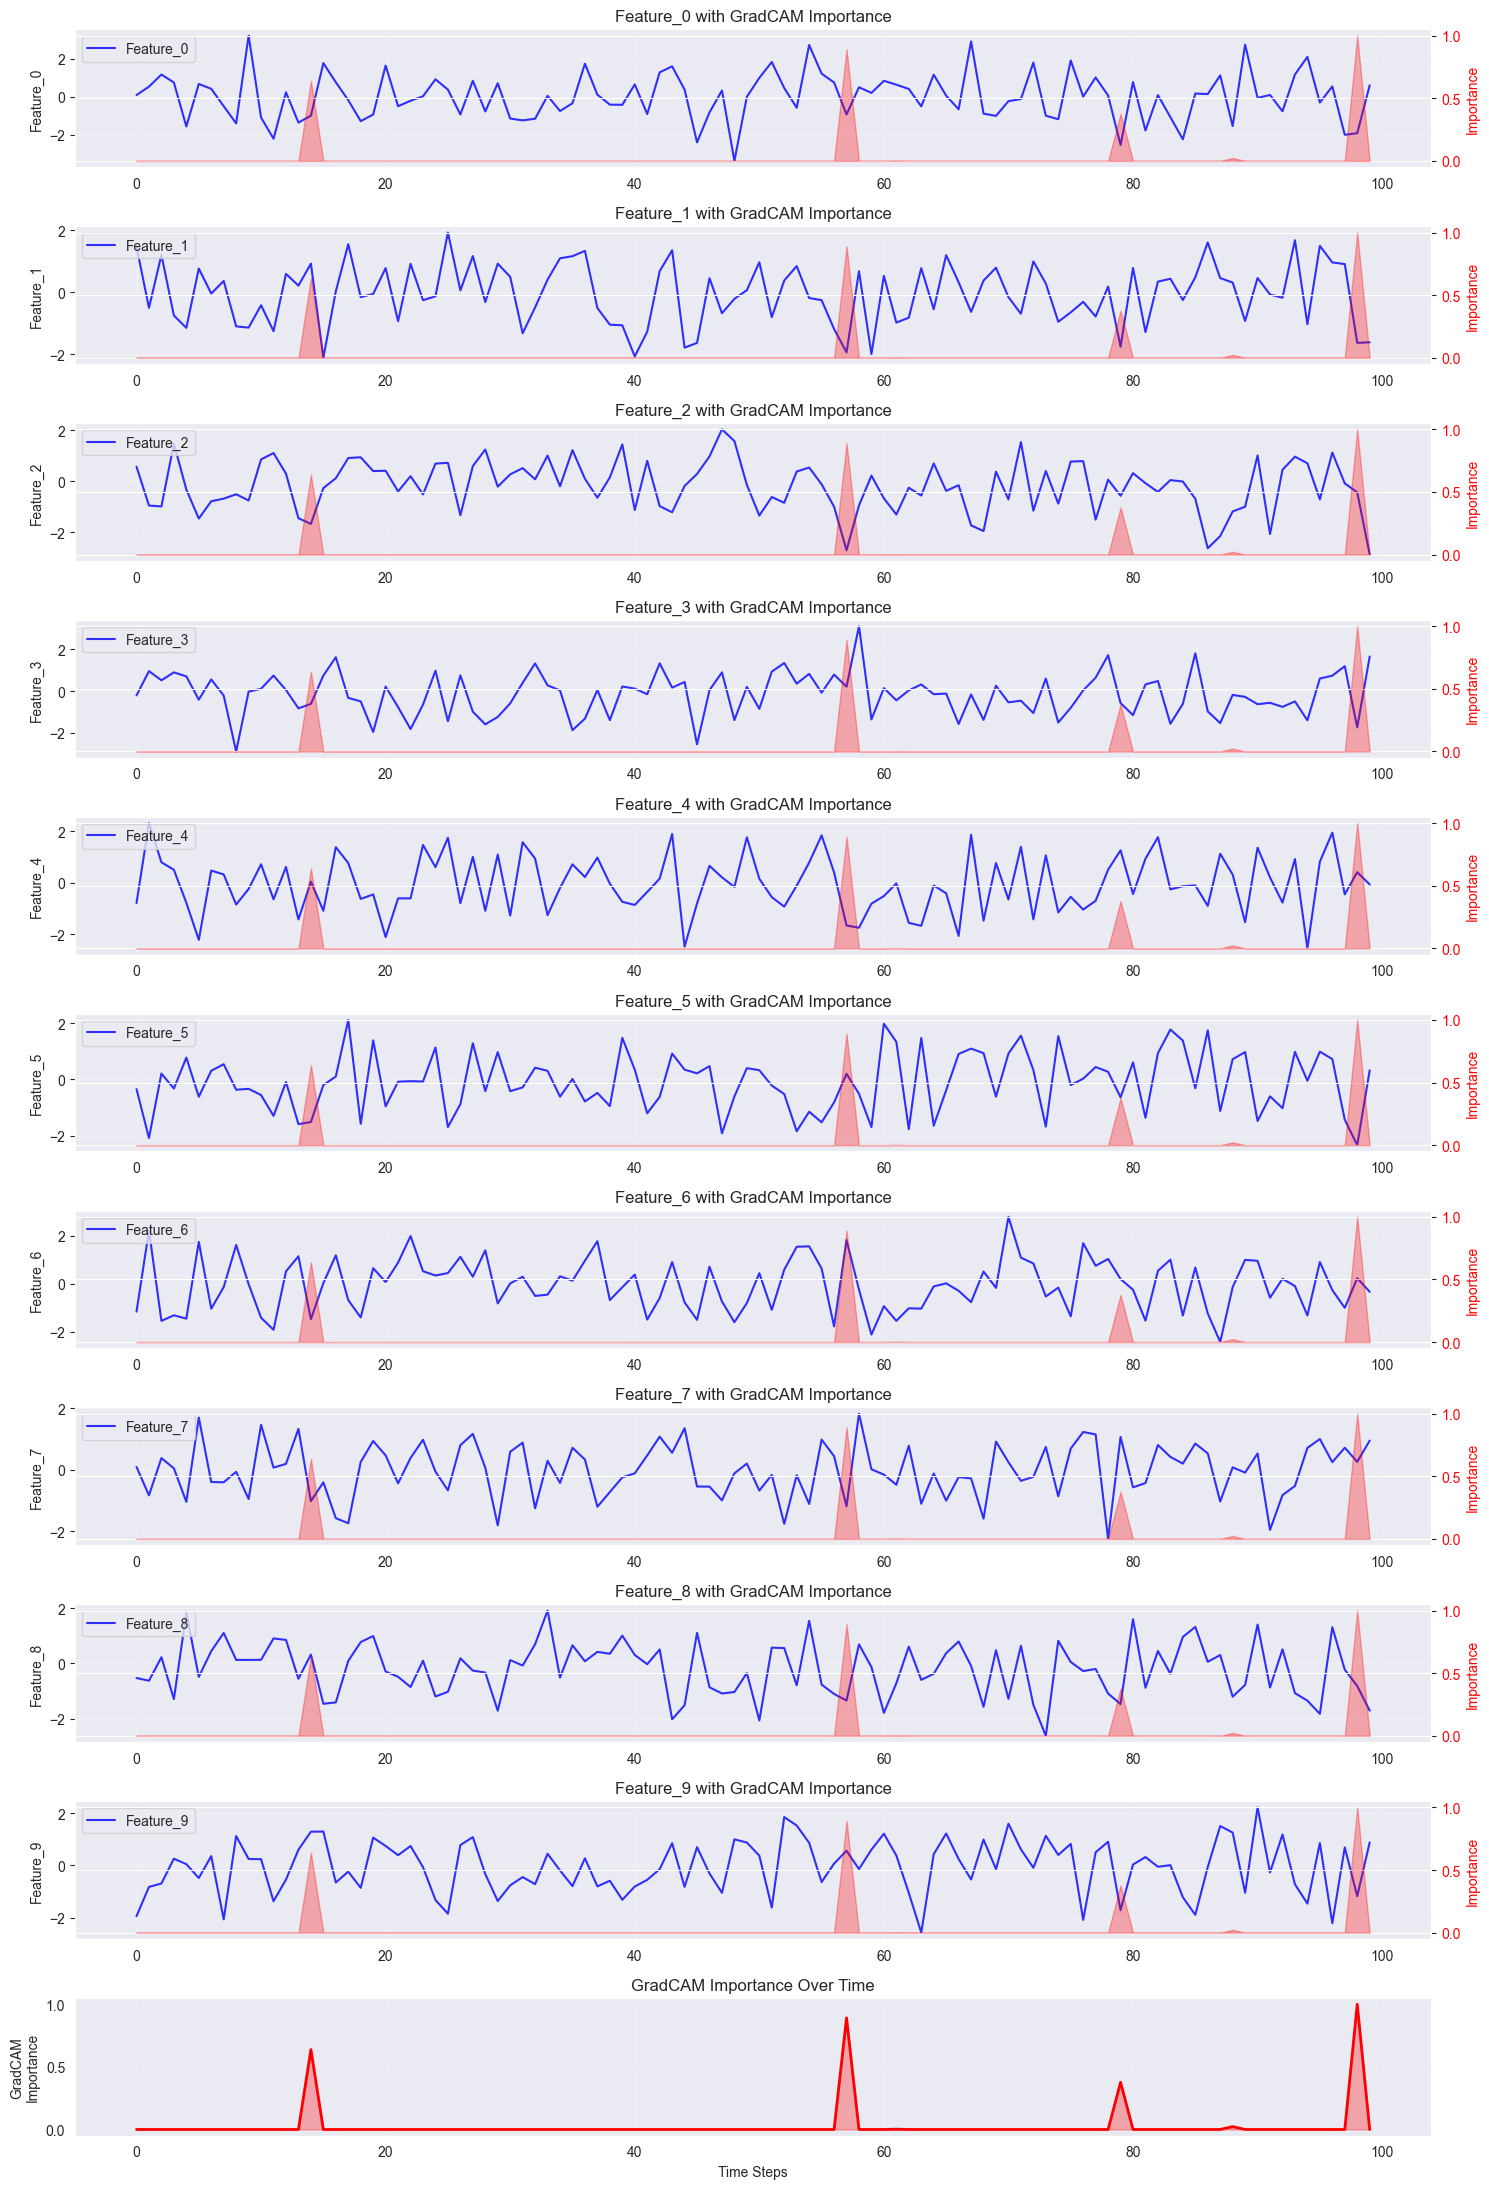

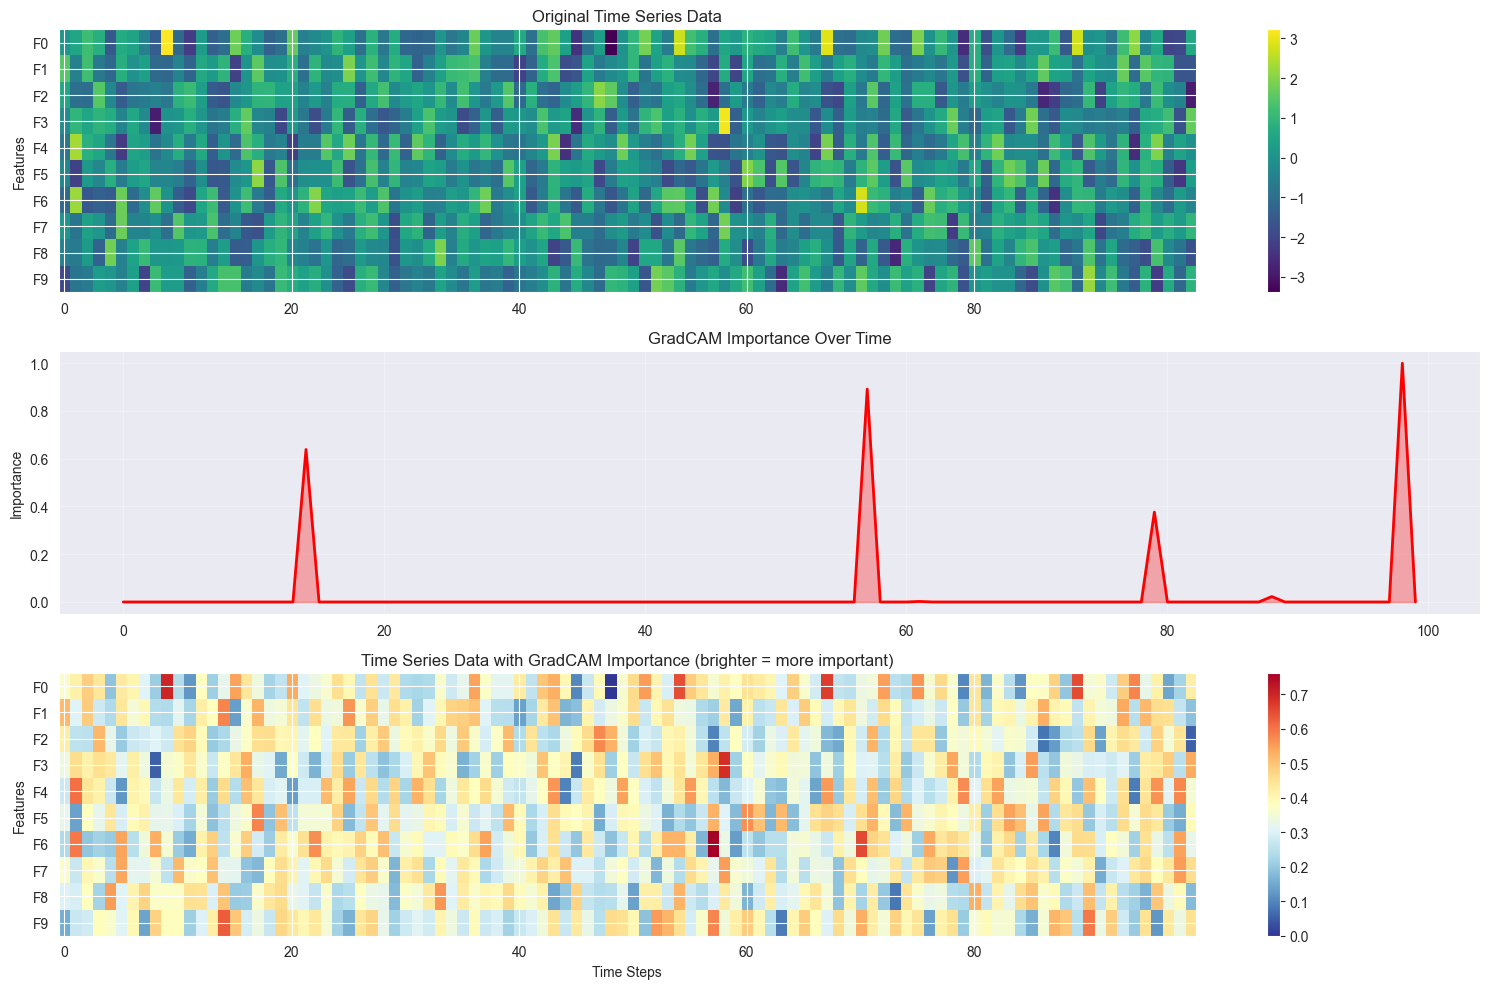


Top 5 most important time steps:
1. Time step 98: importance = 1.0000
2. Time step 57: importance = 0.8915
3. Time step 14: importance = 0.6385
4. Time step 79: importance = 0.3764
5. Time step 88: importance = 0.0227

Results saved to gradcam_timeseries.npz


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Custom GradCAM implementation for time series
class TimeSeriesGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.forward_hook = target_layer.register_forward_hook(self.save_activation)
        self.backward_hook = target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor, target_class=None):
        # Forward pass
        self.model.eval()
        output = self.model(input_tensor)

        # If no target class specified, use the predicted class
        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()

        # Backward pass
        self.model.zero_grad()
        class_loss = output[0, target_class]
        class_loss.backward()

        # Generate CAM
        gradients = self.gradients  # Shape: (batch_size, channels, sequence_length)
        activations = self.activations  # Shape: (batch_size, channels, sequence_length)

        # Global average pooling of gradients
        weights = torch.mean(gradients, dim=2, keepdim=True)  # (batch_size, channels, 1)

        # Weighted combination of activation maps
        cam = torch.sum(weights * activations, dim=1)  # (batch_size, sequence_length)

        # Apply ReLU to get positive contributions only
        cam = F.relu(cam)

        # Normalize to [0, 1]
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()

        return cam, output, target_class

    def __del__(self):
        # Remove hooks
        if hasattr(self, 'forward_hook'):
            self.forward_hook.remove()
        if hasattr(self, 'backward_hook'):
            self.backward_hook.remove()

# Example time series model
class TimeSeriesModel(nn.Module):
    def __init__(self, input_size=10, hidden_size=64, num_classes=3, sequence_length=100):
        super(TimeSeriesModel, self).__init__()
        self.sequence_length = sequence_length
        self.input_size = input_size

        # CNN layers for feature extraction
        self.conv1 = nn.Conv1d(input_size, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)  # Target layer

        # LSTM for sequential processing
        self.lstm = nn.LSTM(128, hidden_size, batch_first=True, bidirectional=True)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        # Transpose for conv1d: (batch_size, input_size, sequence_length)
        x = x.transpose(1, 2)

        # Apply conv layers
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))  # This will be our target layer

        # Transpose back for LSTM: (batch_size, sequence_length, features)
        x = x.transpose(1, 2)

        # LSTM
        lstm_out, (hidden, cell) = self.lstm(x)

        # Use the last output for classification
        output = self.classifier(lstm_out[:, -1, :])

        return output

# Initialize model
model = TimeSeriesModel(input_size=10, hidden_size=64, num_classes=3, sequence_length=100)
model.eval()

# Create sample time series input tensor
batch_size = 1
sequence_length = 100
input_size = 10

# Generate synthetic time series data (replace with your actual data)
np.random.seed(42)
input_tensor = torch.randn(batch_size, sequence_length, input_size)

# Initialize custom GradCAM
gradcam = TimeSeriesGradCAM(model, model.conv3)

# Generate GradCAM
cam_weights, model_output, predicted_class = gradcam.generate_cam(input_tensor)

# Get prediction confidence
confidence = torch.softmax(model_output, dim=1)[0, predicted_class].item()

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.3f}")
print(f"GradCAM shape: {cam_weights.shape}")

# Convert to numpy for visualization
gradcam_weights = cam_weights[0].numpy()  # Remove batch dimension
input_data = input_tensor[0].numpy()  # Remove batch dimension

# Visualization functions
def visualize_time_series_gradcam(input_data, gradcam_weights, feature_names=None):
    """
    Visualize GradCAM results for time series data
    """
    sequence_length, input_size = input_data.shape

    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(input_size)]

    # Create subplots
    fig, axes = plt.subplots(input_size + 1, 1, figsize=(15, 2 * (input_size + 1)))
    if input_size == 1:
        axes = [axes]

    # Time steps
    time_steps = np.arange(sequence_length)

    # Plot each feature with GradCAM overlay
    for i in range(input_size):
        ax = axes[i]

        # Plot the time series
        ax.plot(time_steps, input_data[:, i], 'b-', linewidth=1.5, alpha=0.8, label=f'{feature_names[i]}')

        # Add GradCAM heatmap as background
        ax2 = ax.twinx()
        ax2.fill_between(time_steps, gradcam_weights, alpha=0.3, color='red', label='Importance')
        ax2.set_ylabel('Importance', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        ax.set_ylabel(feature_names[i])
        ax.set_title(f'{feature_names[i]} with GradCAM Importance')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper left')

    # Plot GradCAM weights separately
    ax_gradcam = axes[-1]
    ax_gradcam.plot(time_steps, gradcam_weights, 'r-', linewidth=2)
    ax_gradcam.fill_between(time_steps, gradcam_weights, alpha=0.3, color='red')
    ax_gradcam.set_ylabel('GradCAM\nImportance')
    ax_gradcam.set_xlabel('Time Steps')
    ax_gradcam.set_title('GradCAM Importance Over Time')
    ax_gradcam.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_gradcam_heatmap(input_data, gradcam_weights, feature_names=None):
    """
    Plot a 2D heatmap showing GradCAM importance across time and features
    """
    sequence_length, input_size = input_data.shape

    if feature_names is None:
        feature_names = [f'F{i}' for i in range(input_size)]

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

    # Plot original data
    im1 = ax1.imshow(input_data.T, aspect='auto', cmap='viridis', interpolation='nearest')
    ax1.set_title('Original Time Series Data')
    ax1.set_ylabel('Features')
    ax1.set_yticks(range(input_size))
    ax1.set_yticklabels(feature_names)
    plt.colorbar(im1, ax=ax1)

    # Plot GradCAM importance as 1D plot
    ax2.plot(range(sequence_length), gradcam_weights, 'r-', linewidth=2)
    ax2.fill_between(range(sequence_length), gradcam_weights, alpha=0.3, color='red')
    ax2.set_title('GradCAM Importance Over Time')
    ax2.set_ylabel('Importance')
    ax2.grid(True, alpha=0.3)

    # Plot combined view - original data with importance overlay
    # Normalize input data for better visualization
    normalized_data = (input_data - input_data.min()) / (input_data.max() - input_data.min())

    # Create importance matrix by broadcasting GradCAM weights
    importance_matrix = np.outer(np.ones(input_size), gradcam_weights)

    # Combine data and importance
    combined = normalized_data.T * (0.7 + 0.3 * importance_matrix)

    im3 = ax3.imshow(combined, aspect='auto', cmap='RdYlBu_r', interpolation='nearest')
    ax3.set_title('Time Series Data with GradCAM Importance (brighter = more important)')
    ax3.set_xlabel('Time Steps')
    ax3.set_ylabel('Features')
    ax3.set_yticks(range(input_size))
    ax3.set_yticklabels(feature_names)
    plt.colorbar(im3, ax=ax3)

    plt.tight_layout()
    plt.show()

# Visualize the results
print("\nGenerating visualizations...")
visualize_time_series_gradcam(input_data, gradcam_weights)
plot_gradcam_heatmap(input_data, gradcam_weights)

# Function to find most important time steps
def get_top_important_timesteps(gradcam_weights, top_k=5):
    """Get the most important time steps according to GradCAM"""
    top_indices = np.argsort(gradcam_weights)[-top_k:][::-1]
    top_values = gradcam_weights[top_indices]

    print(f"\nTop {top_k} most important time steps:")
    for i, (idx, val) in enumerate(zip(top_indices, top_values)):
        print(f"{i+1}. Time step {idx}: importance = {val:.4f}")

    return top_indices, top_values

get_top_important_timesteps(gradcam_weights)

# Save results
def save_gradcam_results(input_data, gradcam_weights, predicted_class, confidence, filename='gradcam_timeseries.npz'):
    """Save GradCAM results for later analysis"""
    np.savez(filename,
             input_data=input_data,
             gradcam_weights=gradcam_weights,
             predicted_class=predicted_class,
             confidence=confidence)
    print(f"\nResults saved to {filename}")

save_gradcam_results(input_data, gradcam_weights, predicted_class, confidence)

Input tensor shape: torch.Size([1, 100])
Predicted class: 0
Confidence: 0.354
GradCAM shape: torch.Size([1, 100])
Input data shape: (100,)
GradCAM weights shape: (100,)

Generating visualizations...


/Users/brigt/Documents/GitHub/XAI_time_series/venv_server/lib/python3.11/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


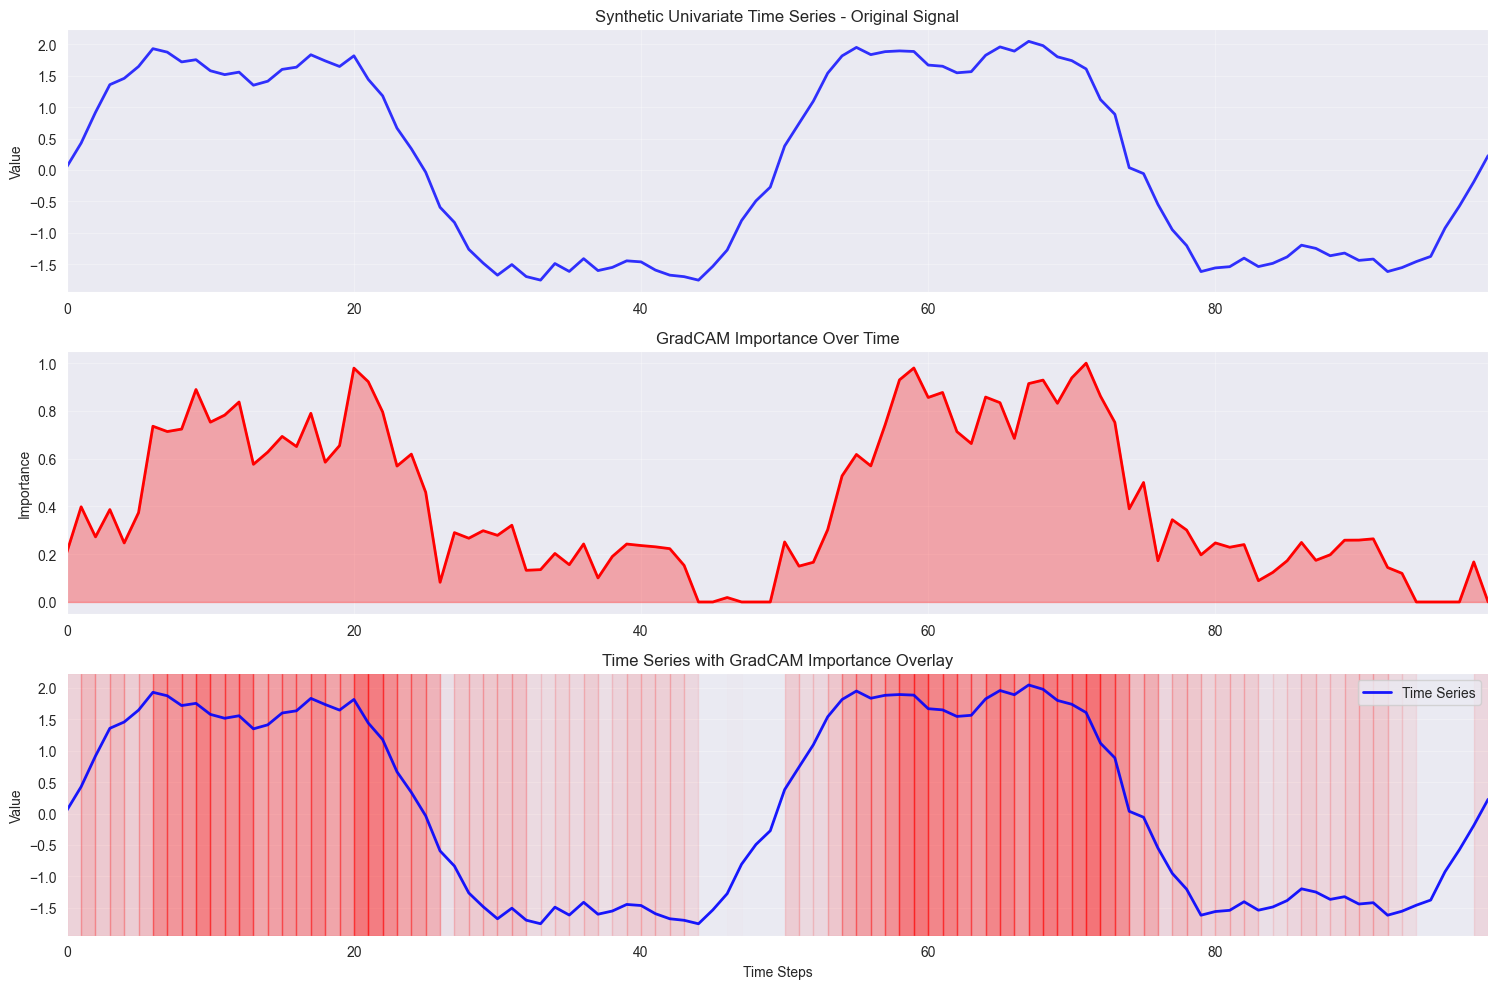

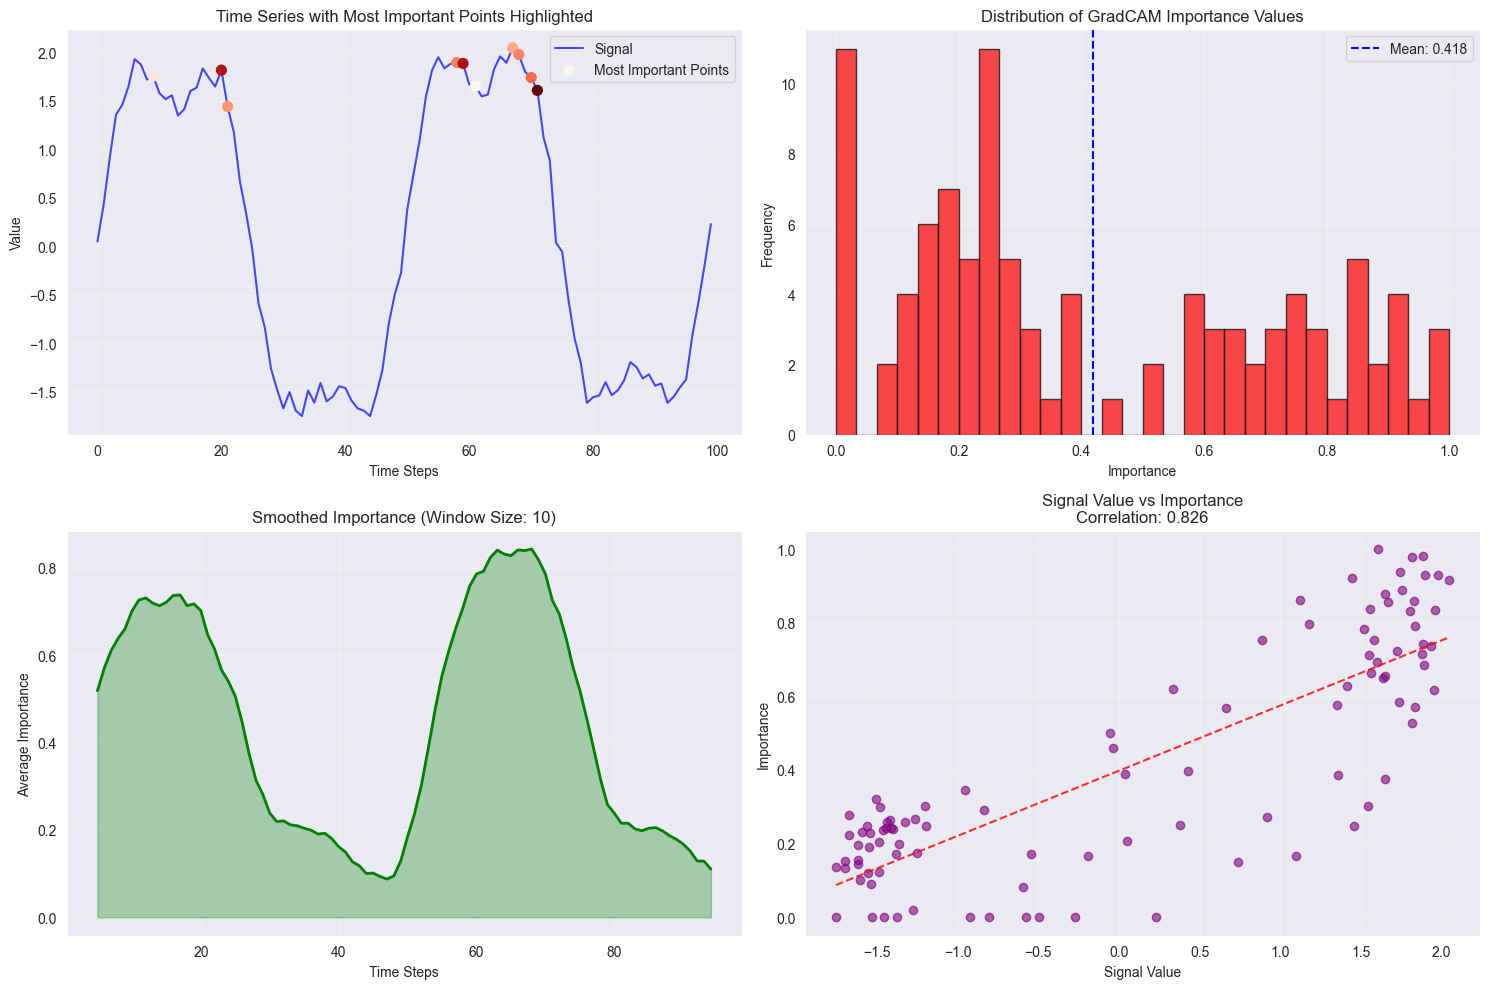


Top 5 most important time steps:
--------------------------------------------------
1. Time step  71: importance = 1.0000, signal value = 1.6084
2. Time step  59: importance = 0.9798, signal value = 1.8865
3. Time step  20: importance = 0.9793, signal value = 1.8174
4. Time step  70: importance = 0.9383, signal value = 1.7406
5. Time step  58: importance = 0.9300, signal value = 1.8957

GradCAM Statistics:
Mean importance: 0.4185
Max importance: 1.0000
Min importance: 0.0000
Std importance: 0.3071

Results saved to univariate_gradcam.npz

TO USE WITH YOUR OWN DATA:

# Load your univariate time series (1D array)
your_data = np.loadtxt('your_timeseries.txt')  # or np.load, pd.read_csv, etc.

# Convert to tensor (add batch dimension)
input_tensor = torch.tensor(your_data).float().unsqueeze(0)

# Apply GradCAM
gradcam = TimeSeriesGradCAM(model, model.conv3)
cam_weights, model_output, predicted_class = gradcam.generate_cam(input_tensor)

# Visualize
gradcam_weights = cam_weights[0].numpy()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Custom GradCAM implementation for time series
class TimeSeriesGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.forward_hook = target_layer.register_forward_hook(self.save_activation)
        self.backward_hook = target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor, target_class=None):
        # Forward pass
        self.model.eval()
        output = self.model(input_tensor)

        # If no target class specified, use the predicted class
        if target_class is None:
            target_class = torch.argmax(output, dim=1).item()

        # Backward pass
        self.model.zero_grad()
        class_loss = output[0, target_class]
        class_loss.backward()

        # Generate CAM
        gradients = self.gradients  # Shape: (batch_size, channels, sequence_length)
        activations = self.activations  # Shape: (batch_size, channels, sequence_length)

        # Global average pooling of gradients
        weights = torch.mean(gradients, dim=2, keepdim=True)  # (batch_size, channels, 1)

        # Weighted combination of activation maps
        cam = torch.sum(weights * activations, dim=1)  # (batch_size, sequence_length)

        # Apply ReLU to get positive contributions only
        cam = F.relu(cam)

        # Normalize to [0, 1]
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()

        return cam, output, target_class

    def __del__(self):
        # Remove hooks
        if hasattr(self, 'forward_hook'):
            self.forward_hook.remove()
        if hasattr(self, 'backward_hook'):
            self.backward_hook.remove()

# Univariate time series model
class UnivariateTimeSeriesModel(nn.Module):
    def __init__(self, hidden_size=64, num_classes=3, sequence_length=100):
        super(UnivariateTimeSeriesModel, self).__init__()
        self.sequence_length = sequence_length

        # CNN layers for feature extraction from single time series
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)  # Target layer

        # Batch normalization and dropout
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.2)

        # LSTM for sequential processing
        self.lstm = nn.LSTM(128, hidden_size, batch_first=True, bidirectional=True, num_layers=2)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length) for univariate
        # Add channel dimension: (batch_size, 1, sequence_length)
        if x.dim() == 2:
            x = x.unsqueeze(1)

        # Apply conv layers with batch norm and dropout
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)

        x = F.relu(self.bn3(self.conv3(x)))  # This will be our target layer
        x = self.dropout(x)

        # Transpose for LSTM: (batch_size, sequence_length, features)
        x = x.transpose(1, 2)

        # LSTM
        lstm_out, (hidden, cell) = self.lstm(x)

        # Use the last output for classification
        output = self.classifier(lstm_out[:, -1, :])

        return output

# Initialize model for univariate time series
model = UnivariateTimeSeriesModel(hidden_size=64, num_classes=3, sequence_length=100)
model.eval()

# Create sample univariate time series input tensor
batch_size = 1
sequence_length = 100

# Generate synthetic univariate time series data (replace with your actual data)
np.random.seed(42)
# Create a more realistic univariate time series with trend and seasonality
t = np.linspace(0, 4*np.pi, sequence_length)
signal = 2 * np.sin(t) + 0.5 * np.sin(3*t) + 0.1 * np.random.randn(sequence_length)
# Add some trend
signal += 0.02 * t
input_tensor = torch.tensor(signal).float().unsqueeze(0)  # Shape: (1, 100)

print(f"Input tensor shape: {input_tensor.shape}")

# Initialize custom GradCAM
gradcam = TimeSeriesGradCAM(model, model.conv3)

# Generate GradCAM
cam_weights, model_output, predicted_class = gradcam.generate_cam(input_tensor)

# Get prediction confidence
confidence = torch.softmax(model_output, dim=1)[0, predicted_class].item()

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.3f}")
print(f"GradCAM shape: {cam_weights.shape}")

# Convert to numpy for visualization
gradcam_weights = cam_weights[0].numpy()  # Remove batch dimension
input_data = input_tensor[0].numpy()  # Remove batch dimension (shape: sequence_length)

print(f"Input data shape: {input_data.shape}")
print(f"GradCAM weights shape: {gradcam_weights.shape}")

# Visualization functions for univariate time series
def visualize_univariate_gradcam(input_data, gradcam_weights, title="Univariate Time Series"):
    """
    Visualize GradCAM results for univariate time series data
    """
    sequence_length = len(input_data)
    time_steps = np.arange(sequence_length)

    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))

    # 1. Original time series
    ax1.plot(time_steps, input_data, 'b-', linewidth=2, alpha=0.8)
    ax1.set_title(f'{title} - Original Signal')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, sequence_length-1)

    # 2. GradCAM importance
    ax2.plot(time_steps, gradcam_weights, 'r-', linewidth=2)
    ax2.fill_between(time_steps, gradcam_weights, alpha=0.3, color='red')
    ax2.set_title('GradCAM Importance Over Time')
    ax2.set_ylabel('Importance')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, sequence_length-1)

    # 3. Combined view - original signal with importance as background
    ax3.plot(time_steps, input_data, 'b-', linewidth=2, alpha=0.9, label='Time Series')

    # Create color gradient based on importance
    colors = plt.cm.Reds(gradcam_weights / (gradcam_weights.max() + 1e-8))

    # Add importance as background shading
    for i in range(len(time_steps) - 1):
        alpha = gradcam_weights[i] * 0.5  # Scale alpha by importance
        ax3.axvspan(time_steps[i], time_steps[i + 1], alpha=alpha, color='red')

    ax3.set_title('Time Series with GradCAM Importance Overlay')
    ax3.set_xlabel('Time Steps')
    ax3.set_ylabel('Value')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    ax3.set_xlim(0, sequence_length-1)

    plt.tight_layout()
    plt.show()

def plot_detailed_analysis(input_data, gradcam_weights):
    """
    Detailed analysis plot with statistics
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    time_steps = np.arange(len(input_data))

    # 1. Time series with importance points
    ax1.plot(time_steps, input_data, 'b-', linewidth=1.5, alpha=0.7, label='Signal')

    # Highlight most important points
    top_indices = np.argsort(gradcam_weights)[-10:]  # Top 10 most important
    ax1.scatter(top_indices, input_data[top_indices],
               c=gradcam_weights[top_indices], cmap='Reds', s=50,
               label='Most Important Points', zorder=5)

    ax1.set_title('Time Series with Most Important Points Highlighted')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Value')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Importance histogram
    ax2.hist(gradcam_weights, bins=30, alpha=0.7, color='red', edgecolor='black')
    ax2.axvline(gradcam_weights.mean(), color='blue', linestyle='--',
                label=f'Mean: {gradcam_weights.mean():.3f}')
    ax2.set_title('Distribution of GradCAM Importance Values')
    ax2.set_xlabel('Importance')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Sliding window analysis
    window_size = 10
    windowed_importance = []
    window_centers = []

    for i in range(window_size//2, len(gradcam_weights) - window_size//2):
        window_imp = gradcam_weights[i-window_size//2:i+window_size//2+1].mean()
        windowed_importance.append(window_imp)
        window_centers.append(i)

    ax3.plot(window_centers, windowed_importance, 'g-', linewidth=2)
    ax3.fill_between(window_centers, windowed_importance, alpha=0.3, color='green')
    ax3.set_title(f'Smoothed Importance (Window Size: {window_size})')
    ax3.set_xlabel('Time Steps')
    ax3.set_ylabel('Average Importance')
    ax3.grid(True, alpha=0.3)

    # 4. Correlation between signal values and importance
    ax4.scatter(input_data, gradcam_weights, alpha=0.6, color='purple')
    correlation = np.corrcoef(input_data, gradcam_weights)[0, 1]
    ax4.set_title(f'Signal Value vs Importance\nCorrelation: {correlation:.3f}')
    ax4.set_xlabel('Signal Value')
    ax4.set_ylabel('Importance')
    ax4.grid(True, alpha=0.3)

    # Add trend line
    z = np.polyfit(input_data, gradcam_weights, 1)
    p = np.poly1d(z)
    ax4.plot(sorted(input_data), p(sorted(input_data)), "r--", alpha=0.8)

    plt.tight_layout()
    plt.show()

# Function to find most important time steps
def get_top_important_timesteps(gradcam_weights, input_data, top_k=5):
    """Get the most important time steps according to GradCAM"""
    top_indices = np.argsort(gradcam_weights)[-top_k:][::-1]
    top_values = gradcam_weights[top_indices]

    print(f"\nTop {top_k} most important time steps:")
    print("-" * 50)
    for i, (idx, val) in enumerate(zip(top_indices, top_values)):
        signal_val = input_data[idx]
        print(f"{i+1}. Time step {idx:3d}: importance = {val:.4f}, signal value = {signal_val:.4f}")

    return top_indices, top_values

# Generate visualizations
print("\nGenerating visualizations...")
visualize_univariate_gradcam(input_data, gradcam_weights, "Synthetic Univariate Time Series")
plot_detailed_analysis(input_data, gradcam_weights)

# Analysis
top_indices, top_values = get_top_important_timesteps(gradcam_weights, input_data)

# Statistics
print(f"\nGradCAM Statistics:")
print(f"Mean importance: {gradcam_weights.mean():.4f}")
print(f"Max importance: {gradcam_weights.max():.4f}")
print(f"Min importance: {gradcam_weights.min():.4f}")
print(f"Std importance: {gradcam_weights.std():.4f}")

# Save results
def save_univariate_results(input_data, gradcam_weights, predicted_class, confidence, filename='univariate_gradcam.npz'):
    """Save GradCAM results for later analysis"""
    np.savez(filename,
             input_data=input_data,
             gradcam_weights=gradcam_weights,
             predicted_class=predicted_class,
             confidence=confidence,
             top_indices=top_indices,
             top_values=top_values)
    print(f"\nResults saved to {filename}")

save_univariate_results(input_data, gradcam_weights, predicted_class, confidence)

# Example of how to load your own univariate data:
print(f"\n" + "="*60)
print("TO USE WITH YOUR OWN DATA:")
print("="*60)
print("""
# Load your univariate time series (1D array)
your_data = np.loadtxt('your_timeseries.txt')  # or np.load, pd.read_csv, etc.

# Convert to tensor (add batch dimension)
input_tensor = torch.tensor(your_data).float().unsqueeze(0)

# Apply GradCAM
gradcam = TimeSeriesGradCAM(model, model.conv3)
cam_weights, model_output, predicted_class = gradcam.generate_cam(input_tensor)

# Visualize
gradcam_weights = cam_weights[0].numpy()
visualize_univariate_gradcam(your_data, gradcam_weights, "Your Time Series")
""")